In [1]:
import pathlib
import numpy as np
from scipy import signal
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam

import m2aia as m2
from SimCLR.code.models import CLR, ContrastiveLoss
from Example_V_Helpers import gaussian_noise, AugmentedDataset
from sklearn import cluster
import umap
import matplotlib.pyplot as plt 
import seaborn

# import os
# from sklearn.manifold import TSNE
# from torch import nn
# import matplotlib.pyplot as plt






/home/jtfc/HS/M2aia/Sources/SpectralClustering/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-06 14:16:39.957745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 14:16:40.453156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib:/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/

In [ ]:
# Clustering Parameters
n_clusters = 10
n_neighbors = 10

# Network Parameters
target_input_size = 124 # model input dimension for height and width of the input images
epochs = 50
batch_size = 64

In [2]:
#===================================
# 1. Download data
#===================================
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([3])

In [3]:
#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f)
    I.SetPooling(m2.m2PoolingMaximum)
    I.SetNormalization(m2.m2NormalizationTIC)
    I.SetBaselineCorrection(m2.m2BaselineCorrectionMedian, 50)
    I.Execute()
    image_handles.append(I)
    print(I.GetShape())
max_dim = np.max(I.GetShape())
print("MaximumDimension", max_dim)

[Tue Dec  6 14:16:41 2022 
7.293] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 224x169
	[image dims]: 5600.000000x4225.000000
[224 169   1]
MaximumDimension 224


In [4]:
#===================================
# 1.1 Pick peaks (mean spectrum)
#===================================
mean = I.GetMeanSpectrum()
min_indices = signal.argrelmin(mean,order=50)[0]
xs = I.GetXAxis()
peaks = signal.find_peaks(mean, height=np.median(mean)*3.5)
centroids = xs[peaks[0]].tolist()
print("Number of centroids", len(centroids))

Number of centroids 393


In [5]:
#===================================
# 1.2 Initialize the ion image Dataset
#===================================
transform_rm_outlies_center_crop_resize = transforms.Compose([
                                          transforms.Lambda(lambda x : torch.Tensor(np.clip(x / np.quantile(x,0.999),0,1))),
                                          transforms.CenterCrop(max_dim),
                                          transforms.Resize(target_input_size)])

dataset = m2.IonImageDataset(image_handles, 
                            centroids=centroids, 
                            tolerance=75, 
                            tolerance_type='ppm', 
                            buffer_type='memory', 
                            transforms=transform_rm_outlies_center_crop_resize)

In [6]:
#===================================
# 1.3 Initialize the augmented ion image 
# Dataset which is used during training
#===================================
# Using: from Example_V_Helpers import gaussian_noise, AugmentedDataset
# Dataset returns two augmentations of the same ion image
blur_kernel_size = 9
augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
                                    transforms.GaussianBlur(blur_kernel_size, sigma=(0.01, 0.75)), 
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), 
                                    transforms.Lambda(gaussian_noise)])
aug_dataset = AugmentedDataset(dataset, augmentations)

In [8]:
#===================================
# 2 Initializing the SimCLR model
#===================================
m = CLR()
m = m.cuda()

# for reproducibility
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_0.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
    torch.save(m.state_dict(), str(model_path))
    

Loaded pretrained weights for efficientnet-b0


In [9]:
#===================================
# 2.1 Predict embeddings of the images
# using the pre-finetuned model
#===================================

m.eval()
A = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if A is None:
        A = embedding
    else:
        A = np.concatenate([A, embedding])

/tmp/ipykernel_200378/125580808.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


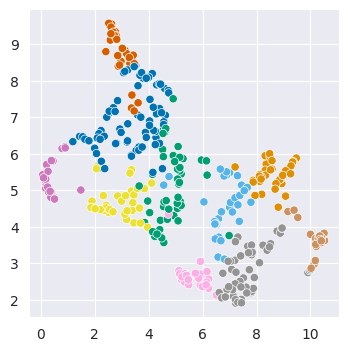

In [10]:
#===================================
# 2.2 Cluster the results using SpectralCustering
#===================================
predictor =  cluster.SpectralClustering(random_state=42,
                                   n_clusters=n_clusters, 
                                   n_neighbors = n_neighbors,
                                   affinity = 'nearest_neighbors', 
                                   assign_labels='discretize')
clusteredA = predictor.fit_predict(A)

#===================================
# 2.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedA = transformer.fit_transform(A)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1],hue=clusteredA, legend=False, palette="colorblind")


# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [11]:
#===================================
# 3 Load trained model parameters
#===================================
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_1.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
#===================================
# 3 Start finetuning and save model
#===================================

    loss = ContrastiveLoss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())
    scheduler = CosineAnnealingLR(optim, epochs)

    dataloader = DataLoader(aug_dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(aug_dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, [X, Y] in enumerate(dataloader):
            X = X.cuda(non_blocking=True)
            Y = Y.cuda(non_blocking=True)
            _, proj_X = m(X)
            _, proj_Y = m(Y)
            loss_value = loss(proj_X, proj_Y)
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))
    
    torch.save(m.state_dict(), str(model_path))

/tmp/ipykernel_200378/1132642036.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  augmentations = transforms.Compose([transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),


epoch 0 loss: 4.448039531707764
epoch 1 loss: 3.878838539123535
epoch 2 loss: 3.6403121948242188
epoch 3 loss: 3.5219480991363525
epoch 4 loss: 3.4460105895996094
epoch 5 loss: 3.381829023361206
epoch 6 loss: 3.3472900390625
epoch 7 loss: 3.323362112045288
epoch 8 loss: 3.3017594814300537
epoch 9 loss: 3.28151535987854
epoch 10 loss: 3.2446234226226807
epoch 11 loss: 3.2243223190307617
epoch 12 loss: 3.204871416091919
epoch 13 loss: 3.181631326675415
epoch 14 loss: 3.1622695922851562
epoch 15 loss: 3.15486741065979
epoch 16 loss: 3.153977155685425
epoch 17 loss: 3.13728404045105
epoch 18 loss: 3.1203296184539795
epoch 19 loss: 3.112926483154297
epoch 20 loss: 3.110941171646118
epoch 21 loss: 3.101599931716919
epoch 22 loss: 3.1037967205047607
epoch 23 loss: 3.0856807231903076
epoch 24 loss: 3.0943775177001953
epoch 25 loss: 3.077453374862671
epoch 26 loss: 3.0847809314727783
epoch 27 loss: 3.0757524967193604
epoch 28 loss: 3.0738000869750977
epoch 29 loss: 3.0790908336639404
epoch 30 l

In [12]:
#===================================
# 3.1 Predict embeddings of the images
# using the finetuned model
#===================================

m.eval()
hatA = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if hatA is None:
        hatA = embedding
    else:
        hatA = np.concatenate([hatA, embedding])

/tmp/ipykernel_200378/186080792.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


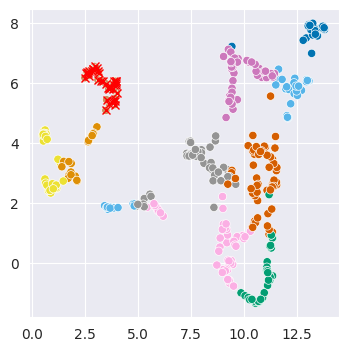

In [13]:
#===================================
# 3.2 Cluster the results using SpectralCustering
#===================================
predictor = cluster.SpectralClustering(random_state=42,
                                n_clusters=n_clusters, 
                                n_neighbors = n_neighbors,
                                affinity = 'nearest_neighbors', 
                                assign_labels='discretize')
clusteredHatA = predictor.fit_predict(hatA)

#===================================
# 3.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedHatA = transformer.fit_transform(hatA)

# highlighted cluster
targetCluster = 5

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
import pandas as pd
# data = pd.DataFrame(np.concatenate([r, c[...,None]],axis=1))

fig = seaborn.scatterplot(x=transformedHatA[:,0], y=transformedHatA[:,1], hue=clusteredHatA ,legend=False, palette='colorblind')
plt.plot(transformedHatA[:,0][clusteredHatA == targetCluster], transformedHatA[:,1][clusteredHatA == targetCluster], 'rx')


# plt.title("B", {'fontweight' : 'bold', 'verticalalignment': 'baseline', 'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS83_post.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.png", dpi=350)

In [ ]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
# r_0 = t.transform(dt_0)
# c_0 = km_0.fit_predict(r_0)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
d = seaborn.color_palette("light:grey", as_cmap=True)
markedClusters = clusteredHatA
markedClusters[markedClusters!=targetCluster] = 250
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1], hue=markedClusters, legend=False, palette=d)
plt.plot(transformedA[:,0][clusteredHatA == targetCluster], transformedA[:,1][clusteredHatA == targetCluster], 'rx')
# plt.plot(r_0[:,0][c == 2], r_0[:,1][c == 2], 'or')
# plt.title("A", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [ ]:
import seaborn_image as isns

ids = np.argwhere(clusteredHatA == targetCluster).flatten().tolist()
images=[]
for id in ids:
    images.append(dataset[id][0])

isns.ImageGrid(images, cbar=False, col_wrap=4)
# plt.savefig(f"{target_path}/FigS8Cluster.png", dpi=350)